<a href="https://colab.research.google.com/github/riccardopezzoni/Covid-19_Impact_on_Mobile_Networks/blob/main/MRN_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Impact of Covid-19 on MN Project -
Riccardo Pezzoni 10575577

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
import geopy.distance
import csv


In [ ]:
##Used to load mount google drive, comment if not needed
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Import Data


In [ ]:
##Edit to use different File path
file_path = '/content/drive/MyDrive/MRNProject/'

# KPIs
data = pd.read_csv(file_path+'Milano_800_January_MRN.csv') # Here January is selected
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])
data2 = pd.read_csv(file_path+'Milano_800_March_MRN.csv') # Here March is selected
data2.drop(['Unnamed: 0'], axis=1, inplace=True)
data2['Date'] = pd.to_datetime(data2['Date'])

# Cells Location:
locations = pd.read_csv(file_path+'Coordinates_MILANO.csv')


In [ ]:
# Show first lines of Location Dataset
locations.drop_duplicates(subset='ECELL_ID').head()

,ENODEB_ID,ECELL_ID,LONG_X,LAT_Y
0,930b285c764e554f338f671864b30d3941935b00,b7de6cd46e855aaec8e28b26d1767e7a738819db,9.208433,45.445358
1,930b285c764e554f338f671864b30d3941935b00,3821116bcdc789c9d54369ddd58b8e75fafdcb59,9.208433,45.445358
2,930b285c764e554f338f671864b30d3941935b00,9ed9d0f30e21c0218c987496c433e11dd611c9d2,9.208433,45.445358
3,930b285c764e554f338f671864b30d3941935b00,9ba7c2a7f2ae3a32003cd92d0ce82fdd734f1d7f,9.208433,45.445358
4,930b285c764e554f338f671864b30d3941935b00,ce8ca39728288e4065ec86b14e902807327427ff,9.208433,45.445358


# Map visualisation


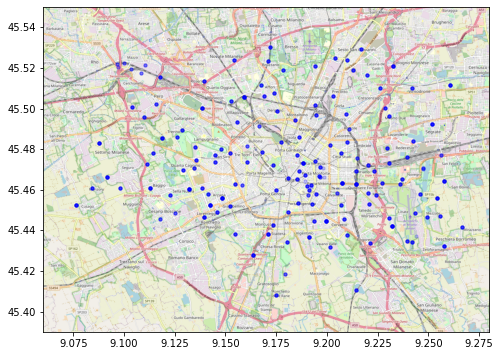

In [ ]:
BBox = ((9.06, 9.28, 45.39, 45.55))
im = plt.imread(file_path+'Milanomap.png')
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(locations.LONG_X, locations.LAT_Y, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(im, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

# Clustering



In [ ]:
# January
week1 = data[data['Date'] < pd.Timestamp(year=2020, month=2, day=16, hour = 23, minute =59)]
week1 = week1[week1['Date'] >= pd.Timestamp(year=2020, month=1, day=6, hour = 00, minute =00)]
week1_m = pd.merge(week1, locations, how='inner', on = "ECELL_ID")
week1_m["TOT_VOL"] = week1_m["DL_VOL"] + week1_m["UL_VOL"]
week1_m = week1_m[["Date", "ECELL_ID", "ENODEB_ID", "TOT_VOL"]]
week1_m["WEEK_DAY"] = week1_m["Date"].dt.dayofweek
week1_m["DATE"] = pd.to_datetime(week1_m["Date"]).dt.date
week1_m["TIME"] = pd.to_datetime(week1_m["Date"]).dt.time
week1_m = week1_m.groupby(["ENODEB_ID","DATE", "WEEK_DAY", "TIME" ]).sum()
week1_sig = week1_m.groupby(["ENODEB_ID","WEEK_DAY", "TIME" ]).median()

#normalization
week1_sig["NORM_TOT_VOL"] = week1_sig["TOT_VOL"]
datas = []
for i in range (0, 973):
  for j in range (0,24):
    datas.append(week1_sig.iloc[i*24+j,0])
  mean = np.mean(datas)
  std = np.std(datas)
  for j in range (0,24):
    week1_sig.iloc[i*24+j,1] = (week1_sig.iloc[i*24+j,0] - mean)/std
  datas = []

week1_sig.drop(["TOT_VOL"], axis=1, inplace=True)

week1_sig

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


NORM_TOT_VOL
ENODEB_ID                                WEEK_DAY TIME                  
0215f23cbc0c6fed80ce30cb131bc9ed2a745328 0        00:00:00      3.092678
                                                  01:00:00      0.575979
                                                  02:00:00      0.395647
                                                  03:00:00     -1.129510
                                                  04:00:00     -1.258810
...                                                                  ...
fedae7d9d5021026b90211ad6e640aba57634d8e 6        19:00:00      0.415539
                                                  20:00:00      0.075564
                                                  21:00:00      0.103101
                                                  22:00:00      0.193578
                                                  23:00:00     -0.428858

[23352 rows x 1 columns]

In [ ]:
matrix = np.zeros((139,168))
matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
x = 0
y = 0
for i,row in week1_sig.iterrows():
  if x == 168: 
    x = 0
    y = y + 1
  matrix[y,x] = row[0]
  x = x +1 


In [ ]:
week1_rev = pd.DataFrame(matrix)
week1_rev

,0,1,2,3,4,5,6,7,8,9,...,158,159,160,161,162,163,164,165,166,167
0,3.092678,0.575979,0.395647,-1.129510,-1.258810,-1.154012,-0.958064,-1.133529,-0.784491,0.457871,...,-0.119870,-0.143390,-0.532699,-0.412770,-0.400831,-0.537795,-0.468469,-0.302244,0.317225,0.211270
1,2.718381,0.991373,-0.704977,-1.205107,-1.504660,-1.425740,-0.725922,-1.272528,-0.742004,-0.622831,...,0.346261,-0.125966,-0.077199,-0.209147,0.289239,0.221343,0.666221,1.753454,0.648630,0.465375
2,1.067136,-0.739148,-0.919128,-1.425127,-1.696598,-1.990151,-1.670663,-0.735417,-0.310527,0.088966,...,0.491925,1.006957,0.332082,-0.007974,0.664130,1.001176,0.356838,1.230486,2.642371,1.456411
3,2.716933,0.926120,0.328369,-0.610959,-1.193524,-1.326763,-1.065906,-1.303035,-1.286781,-0.357655,...,0.513677,0.325420,0.584152,0.242562,0.118474,0.481933,0.719592,1.167338,0.753209,0.264309
4,2.071565,0.058533,-0.742025,-1.214151,-1.495417,-1.567574,-1.281069,-0.966292,-0.925360,-0.690076,...,0.086758,-0.158667,0.366459,-0.107591,0.347283,1.139523,1.624247,1.810456,1.394194,0.715219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,1.449919,0.076935,-1.447050,-1.764288,-2.060992,-1.867527,-0.801018,-0.770717,-0.510037,-0.487214,...,0.704980,0.519192,0.049704,0.360048,1.248044,1.175699,0.484699,1.531223,0.592934,0.235440
135,2.992149,0.461344,-0.342073,-1.118367,-1.346884,-1.219209,-0.960522,-0.802821,-0.752511,-0.682216,...,0.354158,0.096957,-0.297149,-0.257311,-0.330017,0.029895,0.611834,0.825744,-0.007366,-0.373431
136,3.131871,2.250828,0.022634,-0.824807,-1.261703,-1.160515,-1.002113,-0.878591,-0.877650,-0.561224,...,0.389805,-0.532292,-0.346534,0.047982,-0.092402,-0.402049,1.021329,1.630912,1.494306,0.813401
137,2.661411,1.561452,0.882677,-0.093871,-1.563942,-1.575651,-1.294968,-1.434128,-0.749711,-0.681393,...,0.232243,0.203999,0.098221,-0.308723,-0.136293,0.588587,0.897317,0.296285,-0.079898,0.285139


In [ ]:
lst2 = [item[0] for item in list(week1_sig.index.values)]
lst2 = list(dict.fromkeys(lst2))


In [ ]:
mat = week1_rev.values
kmeans = KMeans(n_clusters=3, random_state=6).fit(mat)
results = pd.DataFrame([lst2,kmeans.labels_]).T
results = results.set_index(0)
results.index.name = "ENODEB_ID"
results = results.rename(columns={1: "clusterID"})
results

,clusterID
ENODEB_ID,
0215f23cbc0c6fed80ce30cb131bc9ed2a745328,0
06aae15c9629c9678edd56657192be30db5934d4,0
097e1d4a277e6d01e669ce5cc4451385373f765c,1
0b3ac99f984ed5eebd90e63eb0cd243e80fe0122,0
0c37e6369bb6f6804dd9a9520f9f09e09e659dac,1
...,...
f3d8f663b55d0e09e776e3144bf1ccdb6fad4048,1
f9ea6c0f0f54b40ac1d2a71da53b398109f7b379,0
fad7e3b8304ec998840271a7a79029a250592fe3,0


In [ ]:
results.loc[results['clusterID'] == 0]


,clusterID
ENODEB_ID,
0215f23cbc0c6fed80ce30cb131bc9ed2a745328,0
06aae15c9629c9678edd56657192be30db5934d4,0
0b3ac99f984ed5eebd90e63eb0cd243e80fe0122,0
0c8f79bf01f1c49103a88bf445c27dee9d273b05,0
12779ee606ccef04cdf29f1f64c58761ea7bc6b3,0
15d69ac0b42e5e0d8df547bc94f22d0eb7c5f934,0
179ff76f3959176d80b19303bc41ee4b4bf90b38,0
1ae5c9c225cf16831c86aa7dc5f3cb9c4c08398f,0
1bcec2e44fd7d1ab52f41b77e71bfeef06526a79,0


In [ ]:
results.loc[results['clusterID'] == 1]


,clusterID
ENODEB_ID,
097e1d4a277e6d01e669ce5cc4451385373f765c,1
0c37e6369bb6f6804dd9a9520f9f09e09e659dac,1
12f35b3c5dfea1f73868e8090e0e9c7a91386168,1
12f68937f30417e994ba0f922b08725b2847acd9,1
147c46f4445a6abce1c346450f629fc931a5c41a,1
16be7697a93c534f2b6b7575ae93fe6515c44bde,1
19cb02ac9f3176bd2ad11f16ffdd028385f87bd1,1
1a726ccab48eb7d3f20cce6b8bc7fe50987047c5,1
20dc89dfa2970fba49975c8021d729dbb93d9c86,1


In [ ]:
results.loc[results['clusterID'] == 2]


,clusterID
ENODEB_ID,
0cea9d8394e7e1e3e531061cf123c0bd7cf87375,2
2b77dce36bb3e4b0100b17f4e3f6af8752c1baa4,2
2b863cf732b36359636ed3add517903a483415f0,2
3291b47593a9ea4b4df5d96fd53914184eae0dcb,2
3326677272b5974f36f86b452533b90f49653b48,2
38e236108c3a764c1a94f7941ffe5d8c080ebd58,2
3fdbc872d547a3c5b6404cb90960ed717085fa0b,2
4098516471522b42b596da741a12b408af23877a,2
4fedb13c073ca14a7afb825f4d72275997797ac6,2


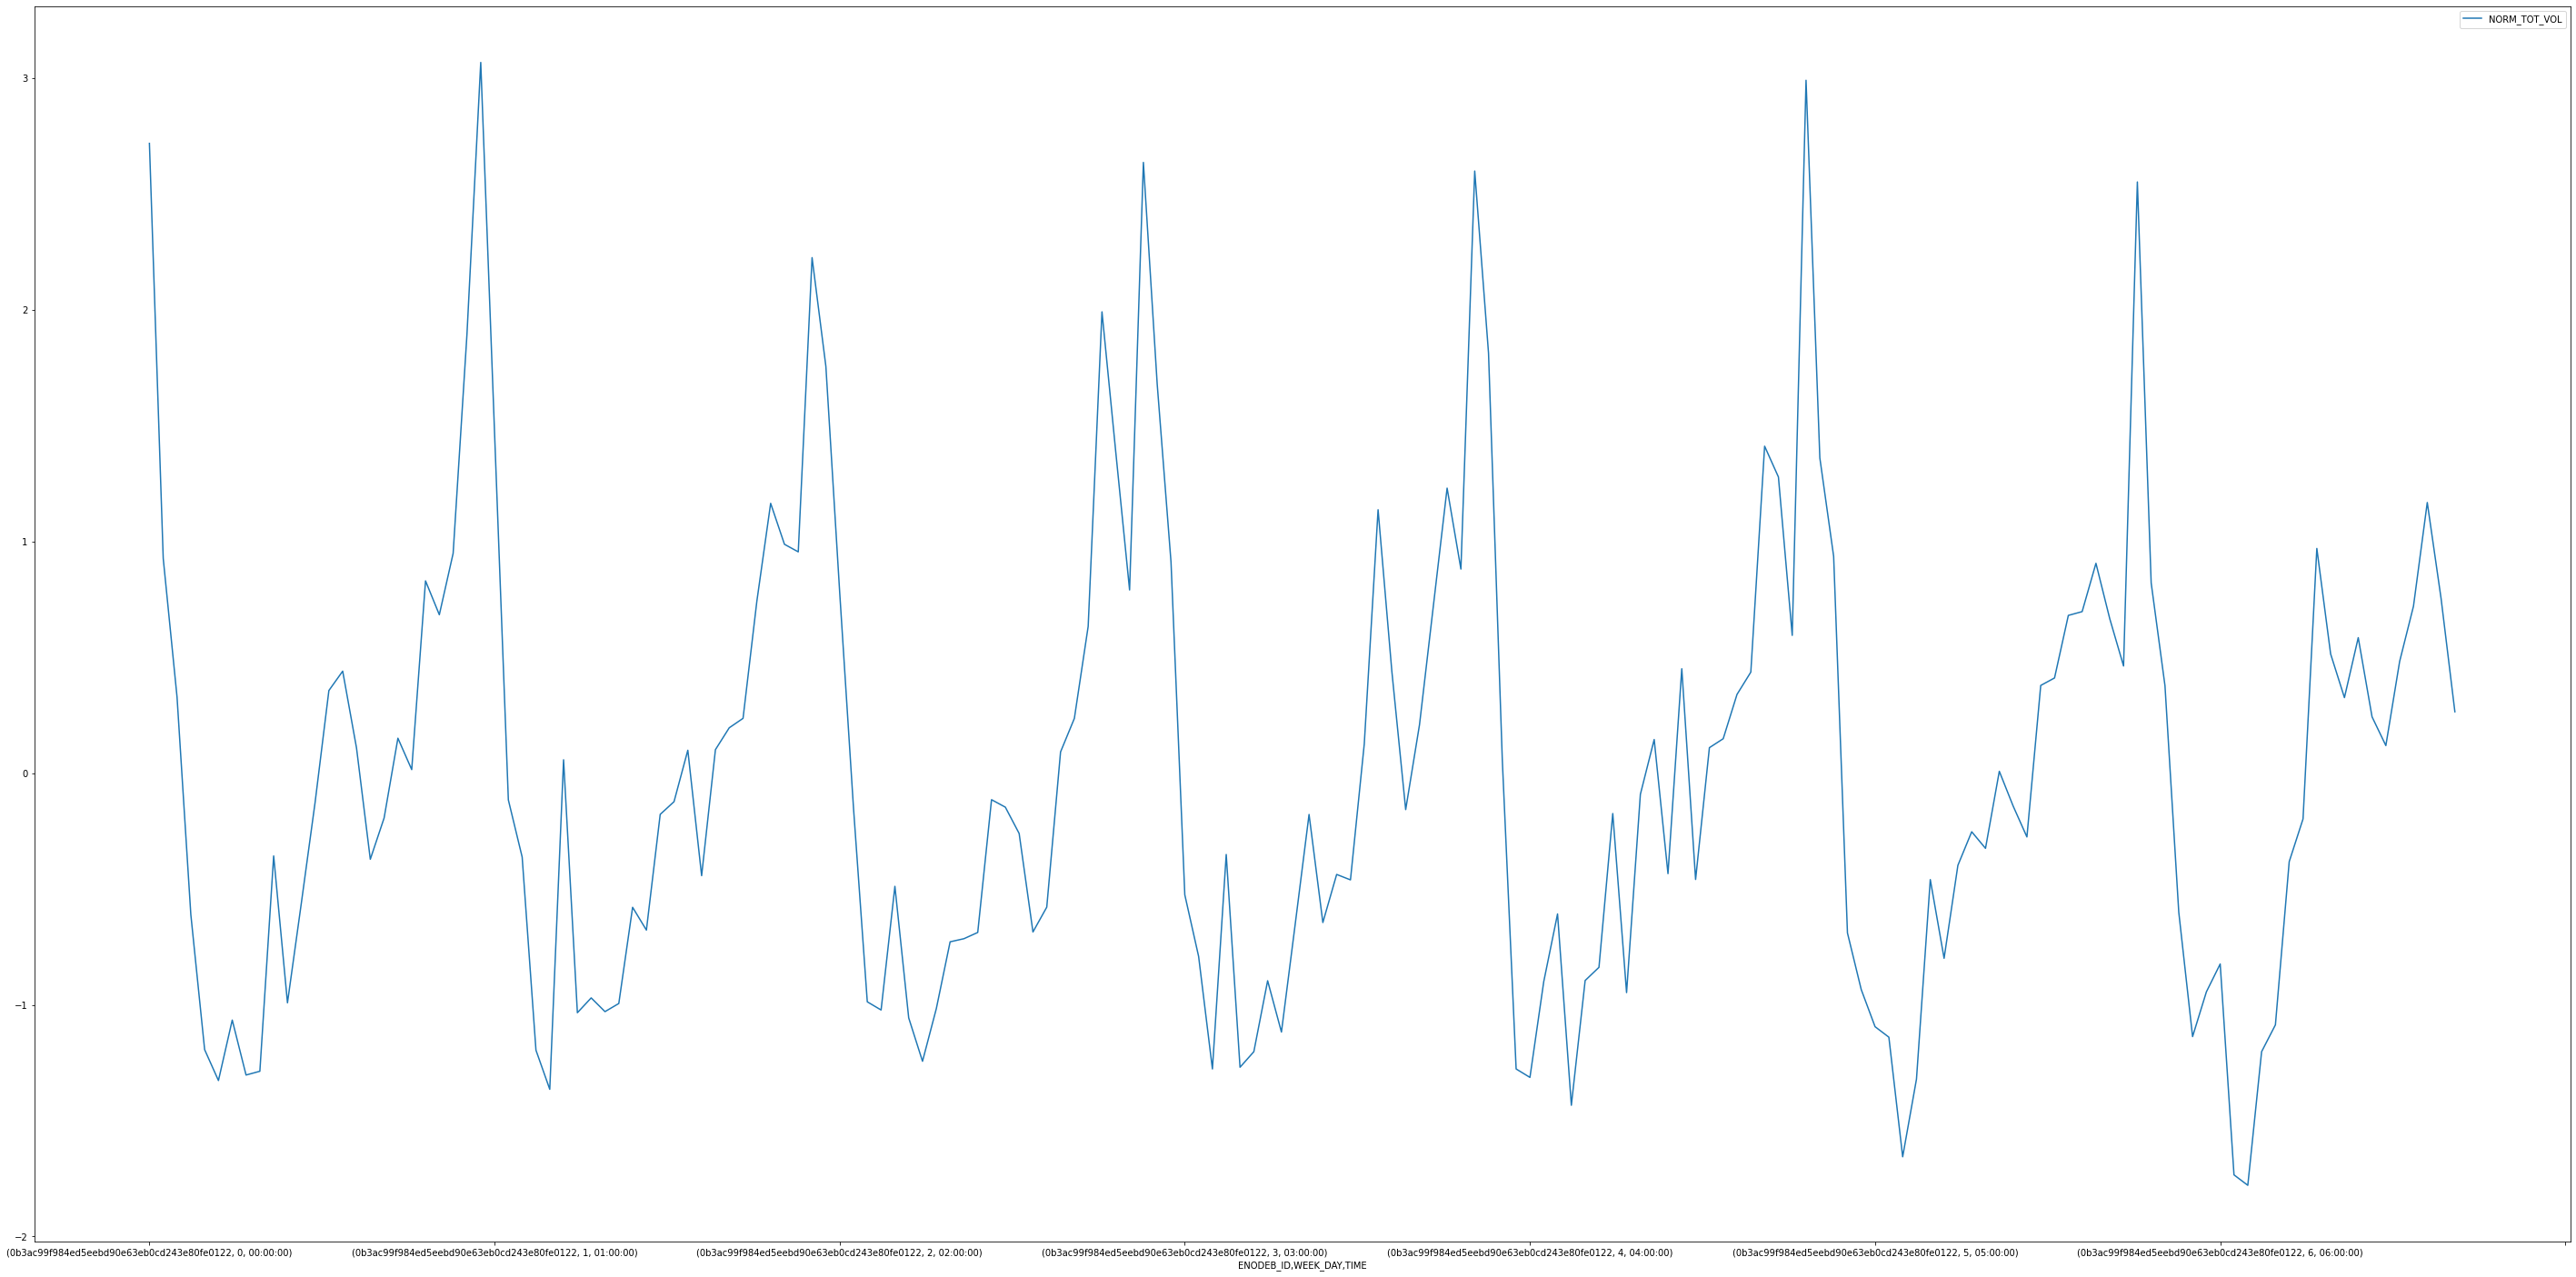

In [ ]:
#clustr 0 cell
temp1 = week1_sig.query('ENODEB_ID == "0b3ac99f984ed5eebd90e63eb0cd243e80fe0122"')
temp1.plot(figsize=(50, 25))

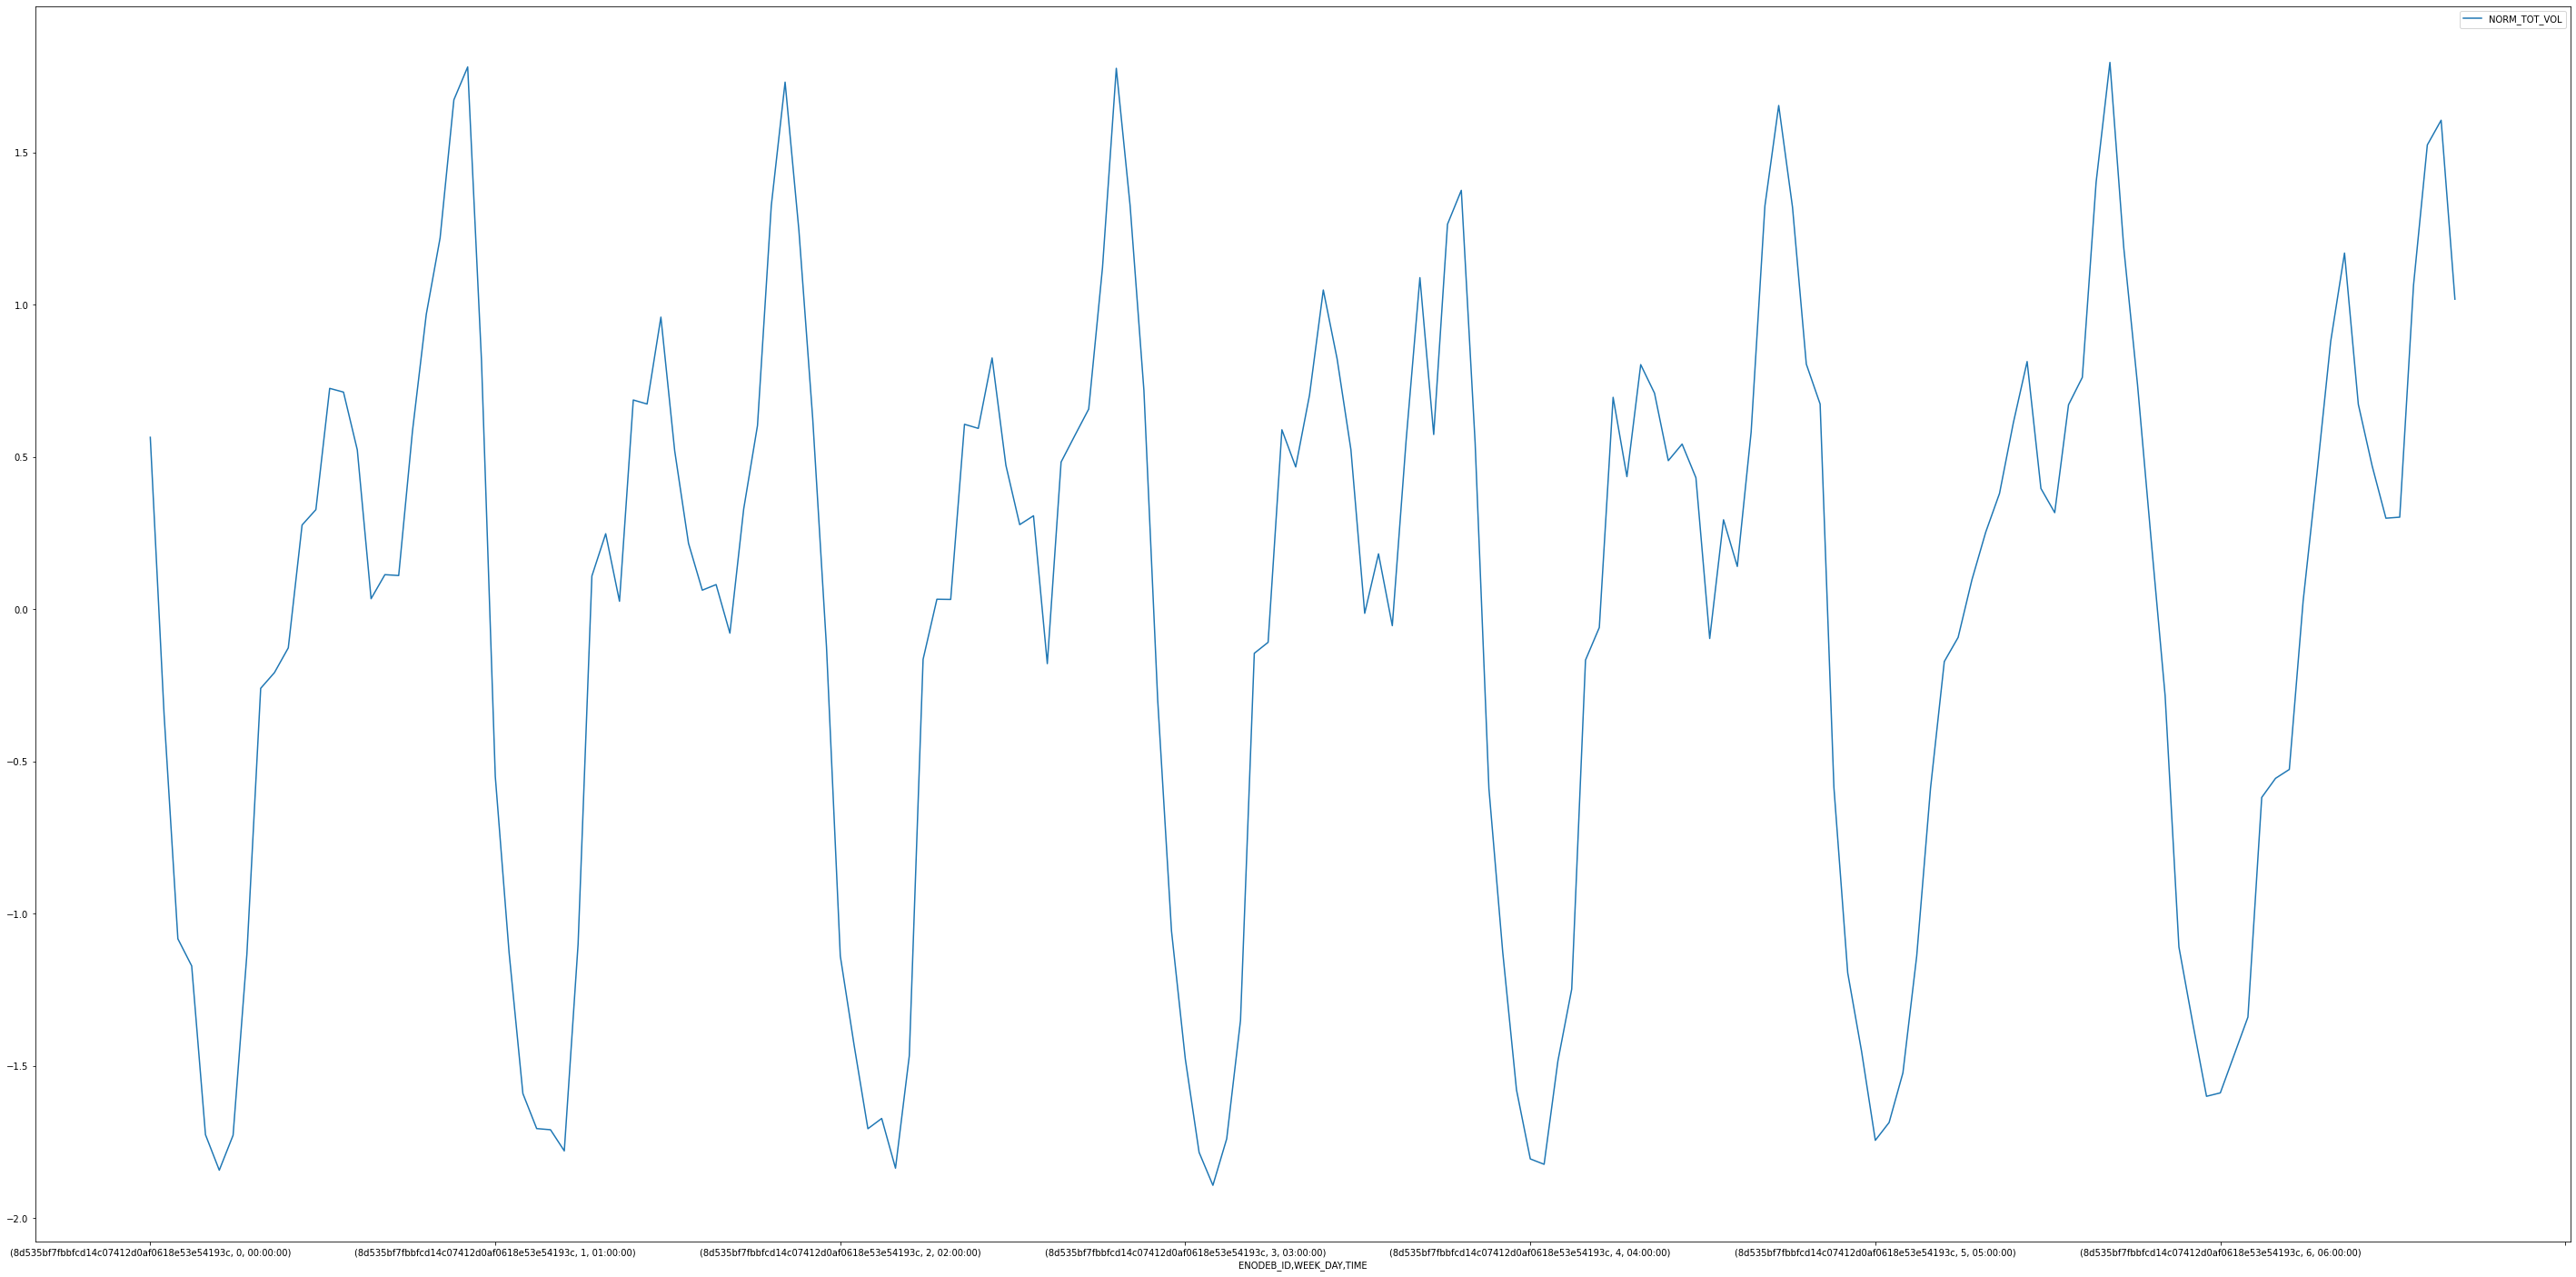

In [ ]:
#clustr 1 cell
temp1 = week1_sig.query('ENODEB_ID == "8d535bf7fbbfcd14c07412d0af0618e53e54193c"')
temp1.plot(figsize=(50, 25))

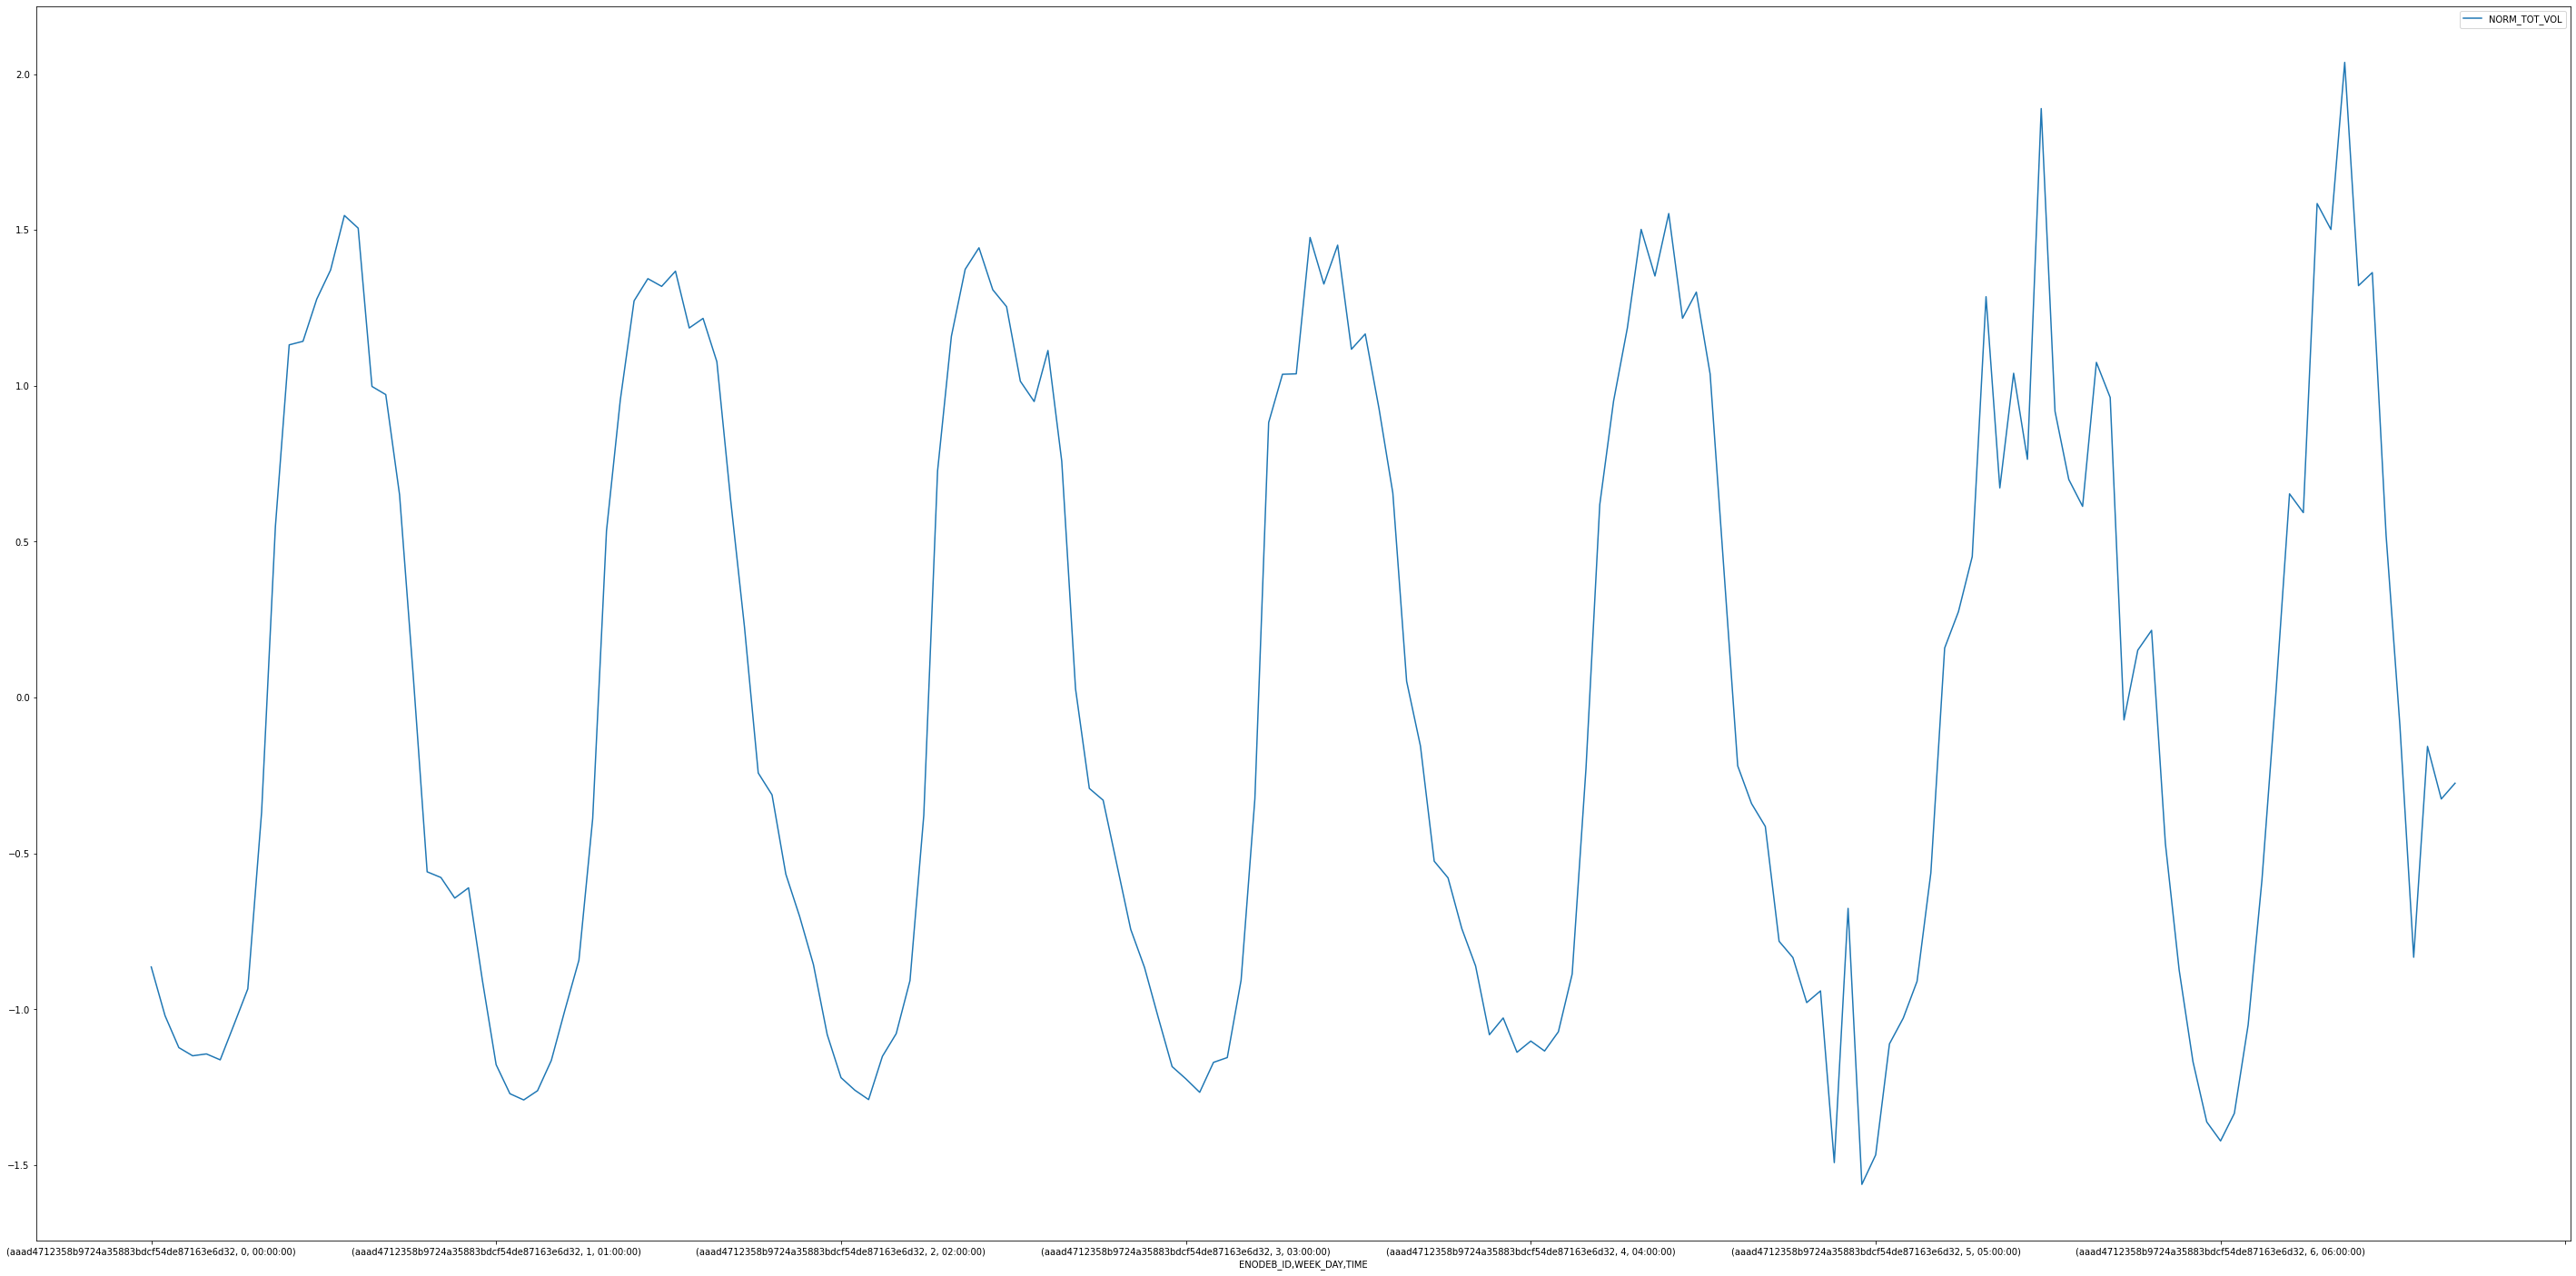

In [ ]:
#cluster 2 cell
temp1 = week1_sig.query('ENODEB_ID == "aaad4712358b9724a35883bdcf54de87163e6d32"')
temp1.plot(figsize=(50, 25))

# Total Volume Analysis 

In [ ]:
#MARCH DATA
week2 = data2[data['Date'] < pd.Timestamp(year=2020, month=3, day=30, hour = 23, minute =59)]
week2 = week2[week2['Date'] >= pd.Timestamp(year=2020, month=3, day=2, hour = 00, minute =00)]
week2_m = pd.merge(week2, locations, how='inner', on = "ECELL_ID")
week2_m["TOT_VOL"] = week2_m["DL_VOL"] + week2_m["UL_VOL"]
week2_m = week2_m[["Date", "ECELL_ID", "ENODEB_ID", "TOT_VOL"]]
week2_m["WEEK_DAY"] = week2_m["Date"].dt.dayofweek
week2_m["DATE"] = pd.to_datetime(week2_m["Date"]).dt.date
week2_m["TIME"] = pd.to_datetime(week2_m["Date"]).dt.time
week2_m = week2_m.groupby(["ENODEB_ID","DATE", "WEEK_DAY", "TIME" ]).sum()
week2_sig = week2_m.groupby(["ENODEB_ID","WEEK_DAY", "TIME" ]).median()


#normalization 
week2_sig["NORM_TOT_VOL"] = week2_sig["TOT_VOL"]
datas = []
for i in range (0, 966):
  for j in range (0,24):
    datas.append(week2_sig.iloc[i*24+j,0])
  mean = np.mean(datas)
  std = np.std(datas)
  for j in range (0,24):
    week2_sig.iloc[i*24+j,1] = (week2_sig.iloc[i*24+j,0] - mean)/std
  datas = []

week2_sig.drop(["TOT_VOL"], axis=1, inplace=True)

week2_sig


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


NORM_TOT_VOL
ENODEB_ID                                WEEK_DAY TIME                  
0215f23cbc0c6fed80ce30cb131bc9ed2a745328 0        00:00:00     -0.630397
                                                  01:00:00      3.044334
                                                  02:00:00      2.647666
                                                  03:00:00      1.719569
                                                  04:00:00      0.440558
...                                                                  ...
fedae7d9d5021026b90211ad6e640aba57634d8e 6        19:00:00      0.535367
                                                  20:00:00      0.670455
                                                  21:00:00      1.370640
                                                  22:00:00      0.763106
                                                  23:00:00      1.901868

[23184 rows x 1 columns]

In [ ]:
week2_daily = week2_m.groupby(["ENODEB_ID","DATE", "WEEK_DAY"]).sum()
week2_daily = week2_daily.groupby(["ENODEB_ID","WEEK_DAY"]).median()
week1_daily = week1_m.groupby(["ENODEB_ID","DATE", "WEEK_DAY"]).sum()
week1_daily = week1_daily.groupby(["ENODEB_ID","WEEK_DAY"]).median()
comparison_daily = week1_daily.merge(week2_daily, how='inner', on = ["ENODEB_ID","WEEK_DAY"])
comparison_daily["DELTA%"] = (comparison_daily["TOT_VOL_y"] - comparison_daily["TOT_VOL_x"])/comparison_daily["TOT_VOL_x"]
comparison_daily

TOT_VOL_x    TOT_VOL_y  \
ENODEB_ID                                WEEK_DAY                             
0215f23cbc0c6fed80ce30cb131bc9ed2a745328 0         577471928.0  650255568.0   
                                         1         581316096.0  605561960.0   
                                         2         665813792.0  586070840.0   
                                         3         557802112.0  671340632.0   
                                         4         556039224.0  546008936.0   
...                                                        ...          ...   
fedae7d9d5021026b90211ad6e640aba57634d8e 2         695239524.0  693102052.0   
                                         3         621403668.0  622144936.0   
                                         4         639033616.0  613638432.0   
                                         5         721727256.0  502331796.0   
                                         6         853997000.0  596725060.0   

                                                     DELTA%  
ENODEB_ID                                WEEK_DAY            
0215f23cbc0c6fed80ce30cb131bc9ed2a745328 0         0.126038  
                                         1         0.041709  
                                         2        -0.119768  
                                         3         0.203546  
                                         4        -0.018039  
...                                                     ...  
fedae7d9d5021026b90211ad6e640aba57634d8e 2        -0.003074  
                                         3         0.001193  
                                         4        -0.039740  
                                         5        -0.303987  
                                         6        -0.301256  

[966 rows x 3 columns]

In [ ]:
comparison_daily.loc["d1fb63c9b3cd91457e81261e1823a6e5e40fbf03"]

,TOT_VOL_x,TOT_VOL_y,DELTA%
WEEK_DAY,,,
0,549246916.0,682411984.0,0.242450
1,512870060.0,649104232.0,0.265631
2,501739096.0,758081664.0,0.510908
3,498009968.0,798686676.0,0.603756
4,525371752.0,729054044.0,0.387692
5,567280832.0,784851756.0,0.383533
6,548054864.0,816885100.0,0.490517


In [ ]:
comparison_daily_c0 = comparison_daily.merge(results.loc[results['clusterID'] == 0], how='inner', on = ["ENODEB_ID"])
comparison_daily_c0["DELTA%"].mean()

0.2554173391817478

In [ ]:
comparison_daily_c1 = comparison_daily.merge(results.loc[results['clusterID'] == 1], how='inner', on = ["ENODEB_ID"])
comparison_daily_c1["DELTA%"].mean()

0.1835740950073968

In [ ]:
comparison_daily_c2 = comparison_daily.merge(results.loc[results['clusterID'] == 2], how='inner', on = ["ENODEB_ID"])
comparison_daily_c2["DELTA%"].mean()

-0.27212801400590736



# RRC Re-Establishment Success Rate



In [ ]:
week1_sr = pd.merge(week1, locations, how='inner', on = "ECELL_ID")
week1_sr = week1_sr[["Date", "ECELL_ID", "ENODEB_ID", "RRC_RE_SR"]]
week1_sr["WEEK_DAY"] = week1_sr["Date"].dt.dayofweek
week1_sr["DATE"] = pd.to_datetime(week1_sr["Date"]).dt.date
week1_sr["TIME"] = pd.to_datetime(week1_sr["Date"]).dt.time
week1_sr = week1_sr.groupby(["ENODEB_ID","WEEK_DAY", "DATE"]).median()
week1_sr = week1_sr.groupby(["ENODEB_ID","WEEK_DAY",]).median()
week2_sr = pd.merge(week2, locations, how='inner', on = "ECELL_ID")
week2_sr = week2_sr[["Date", "ECELL_ID", "ENODEB_ID", "RRC_RE_SR"]]
week2_sr["WEEK_DAY"] = week2_sr["Date"].dt.dayofweek
week2_sr["DATE"] = pd.to_datetime(week2_sr["Date"]).dt.date
week2_sr["TIME"] = pd.to_datetime(week2_sr["Date"]).dt.time
week2_sr = week2_sr.groupby(["ENODEB_ID","WEEK_DAY", "DATE",]).median()
week2_sr = week2_sr.groupby(["ENODEB_ID","WEEK_DAY",]).median()

comparison_sr = week1_sr.merge(week2_sr, how='inner', on = ["ENODEB_ID","WEEK_DAY"])
comparison_sr["DELTA%"] = (comparison_sr["RRC_RE_SR_y"] - comparison_sr["RRC_RE_SR_x"])/comparison_sr["RRC_RE_SR_x"]
comparison_sr

RRC_RE_SR_x  RRC_RE_SR_y  \
ENODEB_ID                                WEEK_DAY                             
0215f23cbc0c6fed80ce30cb131bc9ed2a745328 0           67.566288    66.666667   
                                         1           68.787109    66.666667   
                                         2           66.329164    66.666667   
                                         3           70.020756    65.151515   
                                         4           64.194139    68.141026   
...                                                        ...          ...   
fedae7d9d5021026b90211ad6e640aba57634d8e 2           73.767723    82.843137   
                                         3           72.021104    81.070381   
                                         4           75.000000    80.370370   
                                         5           73.030303    89.322917   
                                         6           68.848485    82.121212   

                                                     DELTA%  
ENODEB_ID                                WEEK_DAY            
0215f23cbc0c6fed80ce30cb131bc9ed2a745328 0        -0.013315  
                                         1        -0.030826  
                                         2         0.005088  
                                         3        -0.069540  
                                         4         0.061484  
...                                                     ...  
fedae7d9d5021026b90211ad6e640aba57634d8e 2         0.123027  
                                         3         0.125648  
                                         4         0.071605  
                                         5         0.223094  
                                         6         0.192782  

[966 rows x 3 columns]

In [ ]:
comparison_sr_c0 = comparison_sr.merge(results.loc[results['clusterID'] == 0], how='inner', on = ["ENODEB_ID"])
comparison_sr_c0["DELTA%"].mean()

0.05751383418489284

In [ ]:
comparison_sr_c1 = comparison_sr.merge(results.loc[results['clusterID'] == 1], how='inner', on = ["ENODEB_ID"])
comparison_sr_c1["DELTA%"].mean()

0.049773996568712675

In [ ]:
comparison_sr_c2 = comparison_sr.merge(results.loc[results['clusterID'] == 2], how='inner', on = ["ENODEB_ID"])
comparison_sr_c2["DELTA%"].mean()

0.09765695161712855

#Total  Average Number of PRB allocated


In [ ]:
week1_aprb = pd.merge(week1, locations, how='inner', on = "ECELL_ID")
week1_aprb = week1_aprb[["Date", "ECELL_ID", "ENODEB_ID", "PRB_DL_Used_Avg", "PRB_UL_Used_Avg"]]
week1_aprb["PRB_AVG"] = week1_aprb["PRB_DL_Used_Avg"] + week1_aprb["PRB_UL_Used_Avg"]
week1_aprb = week1_aprb.drop(["PRB_DL_Used_Avg", "PRB_UL_Used_Avg"], axis = 1)
week1_aprb["WEEK_DAY"] = week1_aprb["Date"].dt.dayofweek
week1_aprb["DATE"] = pd.to_datetime(week1_aprb["Date"]).dt.date
week1_aprb["TIME"] = pd.to_datetime(week1_aprb["Date"]).dt.time
week1_aprb = week1_aprb.groupby(["ENODEB_ID","WEEK_DAY", "DATE"]).mean()
week1_aprb = week1_aprb.groupby(["ENODEB_ID","WEEK_DAY",]).mean()
week2_aprb = pd.merge(week2, locations, how='inner', on = "ECELL_ID")
week2_aprb = week2_aprb[["Date", "ECELL_ID", "ENODEB_ID", "PRB_DL_Used_Avg", "PRB_UL_Used_Avg"]]
week2_aprb["PRB_AVG"] = week2_aprb["PRB_DL_Used_Avg"] + week2_aprb["PRB_UL_Used_Avg"]
week2_aprb = week2_aprb.drop(["PRB_DL_Used_Avg", "PRB_UL_Used_Avg"], axis = 1)
week2_aprb["WEEK_DAY"] = week2_aprb["Date"].dt.dayofweek
week2_aprb["DATE"] = pd.to_datetime(week2_aprb["Date"]).dt.date
week2_aprb["TIME"] = pd.to_datetime(week2_aprb["Date"]).dt.time
week2_aprb = week2_aprb.groupby(["ENODEB_ID","WEEK_DAY", "DATE",]).mean()
week2_aprb = week2_aprb.groupby(["ENODEB_ID","WEEK_DAY",]).mean()

comparison_aprb = week1_aprb.merge(week2_aprb, how='inner', on = ["ENODEB_ID","WEEK_DAY"])
comparison_aprb["DELTA%"] = (comparison_aprb["PRB_AVG_y"] - comparison_aprb["PRB_AVG_x"])/comparison_aprb["PRB_AVG_x"]
comparison_aprb


PRB_AVG_x  PRB_AVG_y  \
ENODEB_ID                                WEEK_DAY                         
0215f23cbc0c6fed80ce30cb131bc9ed2a745328 0          2.455174   2.713430   
                                         1          2.589818   2.595771   
                                         2          2.817049   2.641293   
                                         3          2.526622   2.862882   
                                         4          2.559780   2.640000   
...                                                      ...        ...   
fedae7d9d5021026b90211ad6e640aba57634d8e 2          3.591250   3.568663   
                                         3          3.417084   3.510910   
                                         4          3.483414   3.238828   
                                         5          3.625278   2.807135   
                                         6          4.159410   3.116890   

                                                     DELTA%  
ENODEB_ID                                WEEK_DAY            
0215f23cbc0c6fed80ce30cb131bc9ed2a745328 0         0.105189  
                                         1         0.002299  
                                         2        -0.062390  
                                         3         0.133087  
                                         4         0.031339  
...                                                     ...  
fedae7d9d5021026b90211ad6e640aba57634d8e 2        -0.006289  
                                         3         0.027458  
                                         4        -0.070215  
                                         5        -0.225677  
                                         6        -0.250641  

[966 rows x 3 columns]

In [ ]:
comparison_aprb_c0 = comparison_aprb.merge(results.loc[results['clusterID'] == 0], how='inner', on = ["ENODEB_ID"])
comparison_aprb_c0["DELTA%"].mean()

0.2469092476449558

In [ ]:
comparison_aprb_c1 = comparison_aprb.merge(results.loc[results['clusterID'] == 1], how='inner', on = ["ENODEB_ID"])
comparison_aprb_c1["DELTA%"].mean()

0.21837642910524768

In [ ]:
comparison_aprb_c2 = comparison_aprb.merge(results.loc[results['clusterID'] == 2], how='inner', on = ["ENODEB_ID"])
comparison_aprb_c2["DELTA%"].mean()

-0.23062089735405097

# Outliers

In [ ]:
def findClosest(X, Y):
    with open(file_path+'Coordinates_MILANO.csv') as file:
        reader = csv.DictReader(file)
        dmin = 1000000000
        enodebId = 'xxx'
        for row in reader:
            d = geopy.distance.geodesic((row['LONG_X'], row['LAT_Y']),(Y,X)).km
            if d < dmin :
                enodebId = row['ENODEB_ID']
                dmin = d
        print(enodebId)

In [ ]:
#LINATE AIRPORT
Linate_closestENB = findClosest(45.45446464935626, 9.27644667944278)
print(comparison_daily.loc["d1fb63c9b3cd91457e81261e1823a6e5e40fbf03"])
print(comparison_sr.loc["d1fb63c9b3cd91457e81261e1823a6e5e40fbf03"])

d1fb63c9b3cd91457e81261e1823a6e5e40fbf03
            TOT_VOL_x    TOT_VOL_y    DELTA%
WEEK_DAY                                    
0         549246916.0  682411984.0  0.242450
1         512870060.0  649104232.0  0.265631
2         501739096.0  758081664.0  0.510908
3         498009968.0  798686676.0  0.603756
4         525371752.0  729054044.0  0.387692
5         567280832.0  784851756.0  0.383533
6         548054864.0  816885100.0  0.490517
          RRC_RE_SR_x  RRC_RE_SR_y    DELTA%
WEEK_DAY                                    
0           57.777778    66.666667  0.153846
1           60.000000    66.666667  0.111111
2           58.571429    68.333333  0.166667
3           65.909091    71.914835  0.091122
4           58.571429    66.666667  0.138211
5           66.666667    66.666667  0.000000
6           57.142857    63.333333  0.108333


In [ ]:
#CENTRALE STATION
CentraleStation_closestENB = findClosest(45.48680912667953, 9.2051463929591)
print(comparison_daily.loc["882904d893177df22900dbca554c8d2edaaedc3a"])
print(comparison_sr.loc["882904d893177df22900dbca554c8d2edaaedc3a"])

882904d893177df22900dbca554c8d2edaaedc3a
             TOT_VOL_x    TOT_VOL_y    DELTA%
WEEK_DAY                                     
0         1.148500e+09  849795720.0 -0.260082
1         1.256917e+09  939911856.0 -0.252209
2         1.152117e+09  946757672.0 -0.178246
3         1.143920e+09  986584976.0 -0.137540
4         1.243051e+09  943586056.0 -0.240911
5         1.166915e+09  775696460.0 -0.335259
6         1.073844e+09  750127964.0 -0.301456
          RRC_RE_SR_x  RRC_RE_SR_y    DELTA%
WEEK_DAY                                    
0           72.784366    75.357143  0.035348
1           73.395722    73.400673  0.000067
2           74.043478    76.379127  0.031544
3           68.822821    75.204918  0.092732
4           71.291209    75.183081  0.054591
5           71.960168    74.603175  0.036729
6           75.000000    76.587302  0.021164


In [ ]:
#POLITECNICO DI MILANO
Polimi_closestENB = findClosest(45.47803749615049, 9.227009435113553)
print(comparison_daily.loc["8cf9c6fcfbf3f7ac697ec673cd671a048c25adda"])
print(comparison_sr.loc["8cf9c6fcfbf3f7ac697ec673cd671a048c25adda"])

8cf9c6fcfbf3f7ac697ec673cd671a048c25adda
            TOT_VOL_x    TOT_VOL_y    DELTA%
WEEK_DAY                                    
0         372254996.0  176375632.0 -0.526197
1         359140416.0  149439880.0 -0.583896
2         376863744.0  159753932.0 -0.576096
3         389893916.0  194373776.0 -0.501470
4         353448704.0  180035512.0 -0.490632
5         230330120.0   80846024.0 -0.648999
6         156444888.0  104963088.0 -0.329073
          RRC_RE_SR_x  RRC_RE_SR_y    DELTA%
WEEK_DAY                                    
0           74.862906    71.937500 -0.039077
1           72.952854    70.000000 -0.040476
2           73.706897    69.246032 -0.060522
3           72.474747    70.726496 -0.024122
4           66.666667    70.833333  0.062500
5           75.000000    74.523810 -0.006349
6           75.000000    80.357143  0.071429
